In [1]:
%matplotlib inline
import pandas as pd
import uproot
import matplotlib.pyplot as plt
import numpy as np
import glob

from dask.distributed import Client, LocalCluster
from yahist import Hist1D, Hist2D

from condor_utils import make_htcondor_cluster
import pdroot

In [2]:
from utils import get_results, clear_tree_cache, plot_timeflow

In [3]:
cluster = make_htcondor_cluster()
cluster.scale(8)
cluster

/home/users/namin/miniconda3/envs/newanalysisenv/lib/python3.7/site-packages/distributed/node.py:145: ResourceWarning: unclosed <socket.socket fd=51, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('0.0.0.0', 0)>
  raise
/home/users/namin/miniconda3/envs/newanalysisenv/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 17072 instead
  http_address["port"], self.http_server.port


In [21]:
client = Client(cluster)
client

Client Scheduler: tcp://169.228.130.74:29020 Dashboard: http://169.228.130.74:17072/status,Cluster Workers: 24 Cores: 24 Memory: 96.00 GB


In [22]:
# client.wait_for_workers(5)

In [23]:
fnames = glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/DoubleEG_Run201*x3/*.root")
print(len(fnames))

344


In [24]:
# make a lazy dataframe that materializes as things are drawn/read

# see https://github.com/aminnj/pdroot for drawing info and awkward operations
df = pdroot.ChunkDataFrame(filename=fnames[0], entry_start=0, entry_stop=1000)
df["ht"] = df.draw("sum(Jet_pt[Jet_pt>40])", to_array=True)
_ = df["run"]
# see https://github.com/aminnj/yahist for histogram operations
h = df.draw("ht", "MET_pt>40")
h

[20.00 ± 4.47   33.00 ± 5.74   56.00 ± 7.48   33.00 ± 5.74   45.00 ± 6.71
 24.00 ± 4.90   17.00 ± 4.12    8.00 ± 2.83    4.00 ± 2.00    7.00 ± 2.65
  3.00 ± 1.73    3.00 ± 1.73    4.00 ± 2.00    3.00 ± 1.73    0.00 ± 0.00
  2.00 ± 1.41    0.00 ± 0.00    0.00 ± 0.00    1.00 ± 1.00    0.00 ± 0.00
  0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00    0.00 ± 0.00
  0.00 ± 0.00    0.00 ± 0.00    1.00 ± 1.00    0.00 ± 0.00    1.00 ± 1.00
  0.00 ± 0.00    0.00 ± 0.00    1.00 ± 1.00]

In [25]:
# columns from above have materialized
df.head()

,Jet_pt,ht,run,MET_pt
0,[94.6875 83.8125],178.50000,274315,33.934940
1,[83.0625 47.96875 31.234375],131.03125,274315,29.907625
2,[41.5625 40.1875 26.515625 21.796875],81.75000,274315,46.389805
3,[62.34375 62.1875 61.53125 36.84375 2...,186.06250,274315,30.639101
4,[211.75 172.25 24.171875 23.28125 ...,384.00000,274315,67.491241


In [26]:
# Now wrap all of this in a function that takes a dataframe
# Must return a dictionary of things that can be added with `+`
# which, among other things, includes numbers and yahist's Hist1D/Hist2D
def process(df):
    out = dict()
    out["hmet"] = Hist1D(df["MET_pt"], bins="1000,0,1000")
    out["hnjets"] = df.draw("length(Jet_pt)", "MET_pt>40", bins="20,0,20")
    out["hlead_vs_sublead"] = df.draw("Jet_pt[0]:Jet_pt[1]", "MET_pt>40", bins="50,0,200")
    out["mycounter"] = len(df)
    return out

In [27]:
results = get_results(process, fnames[:20], chunksize=500e3, skip_bad_files=True)

Making chunks for workers
Processing 45 chunks


  0%|          | 0.00/19.6M [00:00<?, ?events/s]

Processed 1.9596e+07 input events in 9.1s (2149.46kHz)


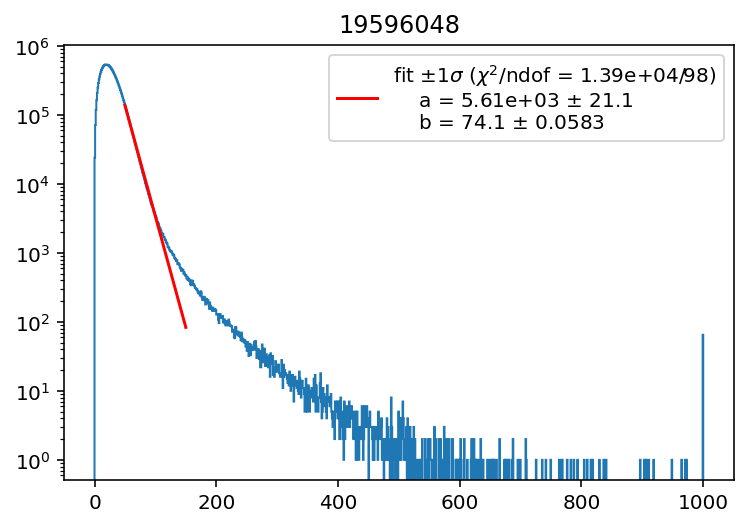

In [28]:
fig, ax = plt.subplots()

h = results["hmet"]

h.plot(histtype="step")
h.restrict(50, 150).fit("(a*1000)*np.exp(-b*x/1000)")

ax.set_title(str(results["mycounter"]))
ax.set_yscale("log")